In [68]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
import re
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [69]:
#Data
corpus= pd.read_csv("../data/groundnews_corpus_cleaned.csv",index_col=0)
corpus.head()

,title,summary,bias,factuality,owner,source,owner_type,source_text,title_s,summary_s,source_text_s
0,Greece legalises sex marriage,Greece ha become the first Christian Orthodox ...,Center,High Factuality,Government of the United Kingdom,https://www.bbc.co.uk/news/world-europe-683101...,Government,legalises same sex marriagePublished1 day agoS...,greec legalis sex marriag,greec ha becom the first christian orthodox ma...,legalis same sex marriagepublished1 day agosha...
1,Greece becomes first Orthodox Christian countr...,Lawmakers in the 300 seat parliament voted for...,Lean Left,Mixed Factuality,Scott Trust Limited,https://www.theguardian.com/world/2024/feb/15/...,Independent,becomes first Christian Orthodox country to le...,greec becom first orthodox christian countri l...,lawmak in the 300 seat parliament vote for the...,becom first christian orthodox countri to lega...
2,Greece legalises sex marriage landmark change,The law give same sex couple the right to wed ...,Lean Left,High Factuality,The Hindu Group,https://www.thehindu.com/news/international/gr...,Independent,Greece legalises same sex marriage in landmark...,greec legalis sex marriag landmark chang,the law give same sex coupl the right to wed a...,greec legalis same sex marriag in landmark cha...
3,Greece becomes first Orthodox Christian countr...,Greece ha become the first Orthodox Christian ...,Center,High Factuality,Bell Media,https://www.ctvnews.ca/world/greece-becomes-fi...,Media Conglomerate,Greece becomes first Orthodox Christian countr...,greec becom first orthodox christian countri l...,greec ha becom the first orthodox christian co...,greec becom first orthodox christian countri t...
4,Greece legalises sex marriage another Orthod...,Greece ha become the first majority Orthodox C...,Lean Left,Mixed Factuality,Evgeny Lebedev,https://www.independent.co.uk/news/world/europ...,Individual,Jump to contentUS EditionChangeUK EditionAsia...,greec legalis sex marriag anoth orthodox chr...,greec ha becom the first major orthodox christ...,jump to contentu editionchangeuk editionasia ...


In [70]:
#Making Vectorizers
MyVect=CountVectorizer(input='content',
                        stop_words='english',
                        token_pattern='(?u)[a-zA-Z]+',
                        lowercase = True
                        )

MyVect_TFIDF=TfidfVectorizer(input='content',
                        analyzer = 'word',
                        stop_words='english',
                        token_pattern='(?u)[a-zA-Z]+',
                        lowercase = True,
                        #binary=True
                        )

In [71]:
#Converting the Ground News Data into a WDM
def create_wdm(corpus,index,cv):
    df = pd.DataFrame(cv.fit_transform(corpus[index]).toarray(),columns=cv.get_feature_names_out())
    return df.filter(regex='(?u)[a-zA-Z]{3}+')
count_wdm = create_wdm(corpus,'title',MyVect)
tfidf_wdm = create_wdm(corpus,'title',MyVect_TFIDF)
wdms=[count_wdm,tfidf_wdm]
bias={'Far Left':-3,'Left':-2,'Lean Left':-1,'Center':0,'Lean Right':1,'Right':2,'Far Right':3}
factuality={'Low Factuality':0,'Mixed Factuality':1,'High Factuality':2}
owner_type={'Other':-1,'Corporation':0,'Government':1,'Independent':2,'Individual':3,'Media Conglomerate':4,'Private Equity':5}
for wdm in wdms:
    wdm['bias']=corpus['bias'].map(bias).fillna(0)
    wdm['factuality']=corpus['factuality'].map(factuality).fillna(-1)
    wdm['owner_type']=corpus['owner_type'].map(owner_type).fillna(1)

In [72]:
#Creating Training and Testing Datasets.
rd.seed(1234)
TrainCount, TestCount = train_test_split(count_wdm, test_size=0.3)
TrainTFIDF, TestTFIDF = train_test_split(tfidf_wdm, test_size=0.3)

TrainCountLabels=TrainCount[['bias','owner_type','factuality']]
TrainTFIDFLabels=TrainTFIDF[['bias','owner_type','factuality']]
TestCountLabels=TestCount[['bias','owner_type','factuality']]
TestTFIDFLabels=TestTFIDF[['bias','owner_type','factuality']]

TrainCount=TrainCount.drop(['bias','owner_type','factuality'],axis=1)
TrainTFIDF=TrainTFIDF.drop(['bias','owner_type','factuality'],axis=1)
TestCount=TestCount.drop(['bias','owner_type','factuality'],axis=1)
TestTFIDF=TestTFIDF.drop(['bias','owner_type','factuality'],axis=1)

C:\Users\Owner\anaconda3\envs\DataScience3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



The confusion matrix is:
[[ 0  2  1  0  0  0]
 [ 0 19 17  1  0  0]
 [ 0 20 15  4  3  0]
 [ 0  2  3  1  1  0]
 [ 0  1  4  2  4  3]
 [ 0  0  0  0  2  0]]




The confusion matrix is:
[[ 0  0  3  0  0  0]
 [ 0 15 22  0  0  0]
 [ 0 13 25  2  2  0]
 [ 0  2  5  0  0  0]
 [ 0  0 12  0  2  0]
 [ 0  0  2  0  0  0]]




The confusion matrix is:
[[ 0  0  3  0  0  0]
 [ 0 15 21  1  0  0]
 [ 0  9 27  4  2  0]
 [ 0  1  5  1  0  0]
 [ 0  0  9  3  2  0]
 [ 0  0  2  0  0  0]]





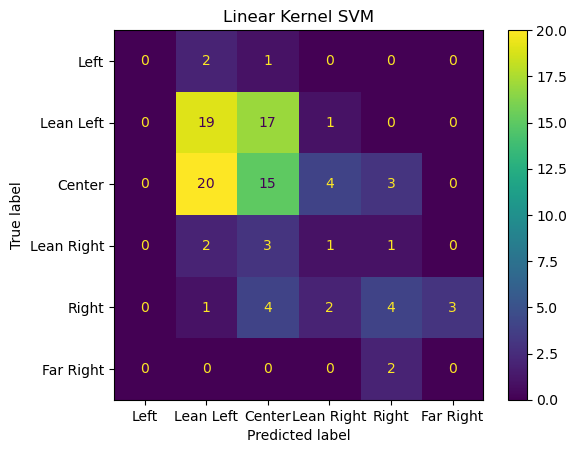

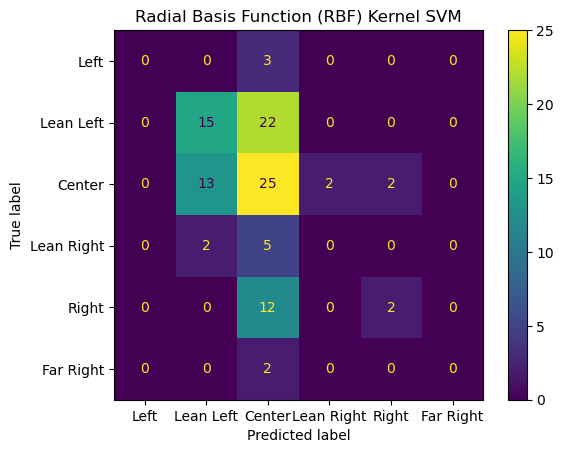

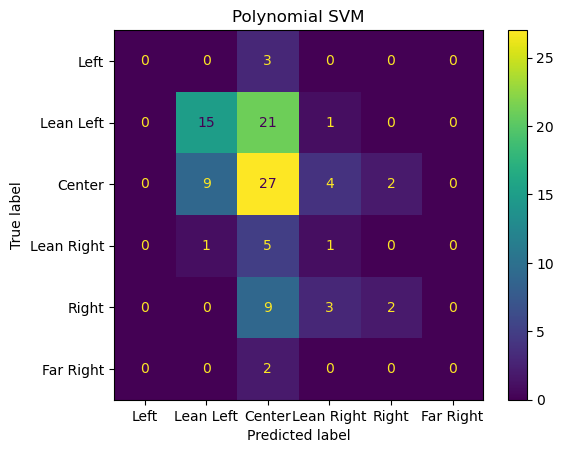

In [73]:
SVM_Model=LinearSVC(C=1)

SVM_Model.fit(TrainCount, TrainCountLabels.iloc[:,0])
SVM_matrix = confusion_matrix(TestCountLabels.iloc[:,0], SVM_Model.predict(TestCount))
print("\nThe confusion matrix is:")
print(SVM_matrix)
ConfusionMatrixDisplay(confusion_matrix = SVM_matrix, 
                                            display_labels = ["Left","Lean Left","Center","Lean Right","Right","Far Right"]).plot()
plt.title("Linear Kernel SVM")
print("\n\n")

SVM_Model2=sklearn.svm.SVC(C=1, kernel='rbf')
SVM_Model2.fit(TrainCount, TrainCountLabels.iloc[:,0])
SVM_matrix2 = confusion_matrix(TestCountLabels.iloc[:,0], SVM_Model2.predict(TestCount))
print("\nThe confusion matrix is:")
print(SVM_matrix2)
ConfusionMatrixDisplay(confusion_matrix = SVM_matrix2, 
                                            display_labels = ["Left","Lean Left","Center","Lean Right","Right","Far Right"]).plot()
plt.title("Radial Basis Function (RBF) Kernel SVM")
print("\n\n")

SVM_Model3=sklearn.svm.SVC(C=100, kernel='poly')
SVM_Model3.fit(TrainCount, TrainCountLabels.iloc[:,0])
SVM_matrix3 = confusion_matrix(TestCountLabels.iloc[:,0], SVM_Model3.predict(TestCount))
print("\nThe confusion matrix is:")
print(SVM_matrix3)
ConfusionMatrixDisplay(confusion_matrix = SVM_matrix3, 
                                            display_labels = ["Left","Lean Left","Center","Lean Right","Right","Far Right"]).plot()
plt.title("Polynomial SVM")
print("\n\n")


C:\Users\Owner\anaconda3\envs\DataScience3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


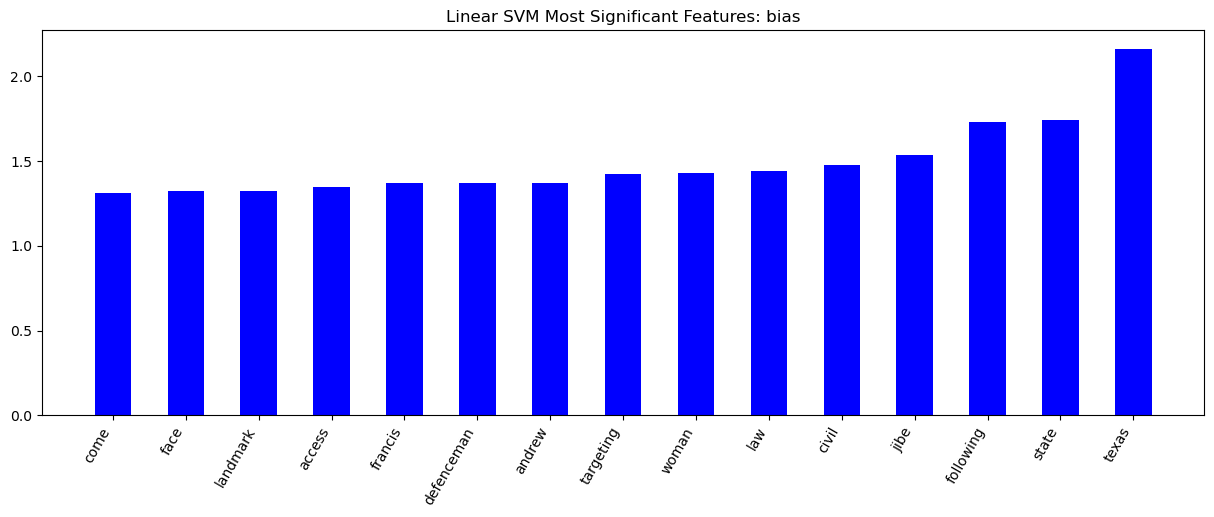

C:\Users\Owner\anaconda3\envs\DataScience3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


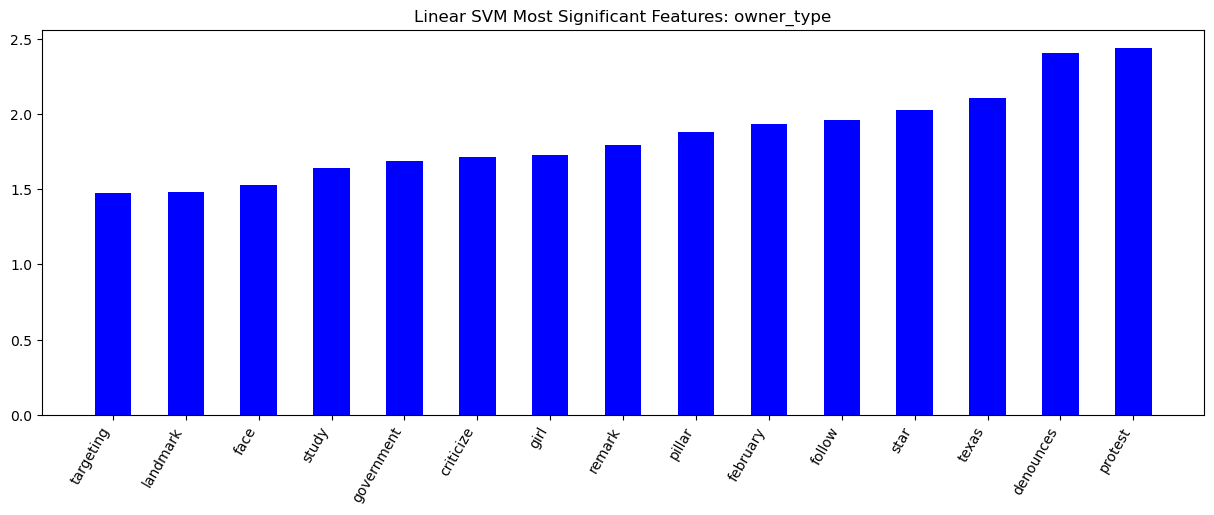

C:\Users\Owner\anaconda3\envs\DataScience3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


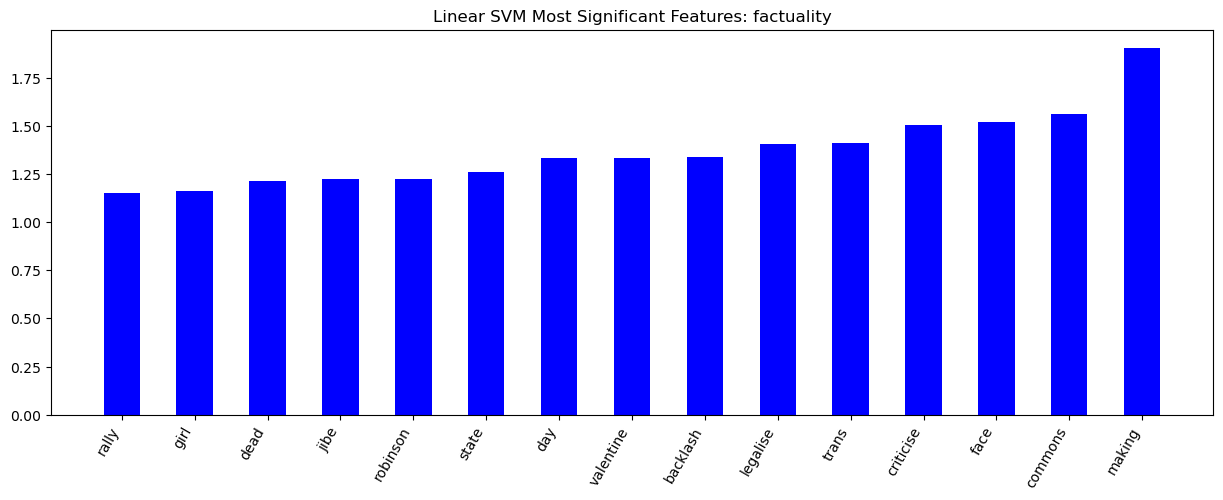

In [74]:
def plot_coefficients(model=SVM_Model, colnames=TrainCount.columns, top_features=15,title='Bias'):
    ## Model if SVM MUST be SVC, RE: SVM_Model=LinearSVC(C=10)
    coef = np.absolute(model.coef_).sum(axis=0).ravel()
    top_coefficients = np.argsort(coef,axis=0)[-top_features:]
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(  x=  np.arange(top_features), height=coef[top_coefficients], width=.5,  color=colors)
    feature_names = np.array(colnames)
    plt.xticks(np.arange(0, (top_features)), feature_names[top_coefficients], rotation=60, ha="right")
    plt.title('Linear SVM Most Significant Features: '+title)
    plt.show()
    

for i in range(3):
    SVM_Model.fit(TrainCount, TrainCountLabels.iloc[:,i])
    plot_coefficients(title=TrainCountLabels.columns[i])